<a href="https://colab.research.google.com/github/space-owner/Tensorflow-2/blob/main/002_basic_text_classification_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Basic Text Classification***
This post is **based on the Tensorflow tutorial** for study purposes. [Link](https://www.tensorflow.org/)   
If you get a chance, be sure to try the this tutorial.

Now let's **Basic Text Classification** review, we go through four steps.
- Download the IMDB dataset.
- Pre process the dataset for train.
- Create the model, loss function and optimizer.
- Evaluate accuracy and loss in the model.

### ***Get libraries***

In [ ]:
import os
import re
import shutil
import string
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print("[INFO] Tensorflow version:", tf.__version__)

[INFO] Tensorflow version: 2.6.0


### ***Download the IMDB dataset***

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir=''
)

dataset_dir = os.path.join(
    os.path.dirname(dataset), 'aclImdb'
)

print("[INFO] Detail directory: {list_in_directory} in {directory}".format(
    list_in_directory=", ".join(os.listdir(dataset_dir)), directory=dataset_dir)
)

[INFO] Detail directory: imdb.vocab, imdbEr.txt, README, train, test in ./aclImdb


### ***Look over a text file***

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')

sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

with open(sample_file) as f:
    print("[INFO] Sample text:", f.read())

remove_dir = os.path.join(train_dir, 'unsup')

shutil.rmtree(remove_dir)

[INFO] Sample text: Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### ***Load a train dataset***
There are 25,000 examples in the training folder, of which you will use 80% (20,000) for training.

We will use the remaining 5,000 reviews from the training set for validation.


In [ ]:
batch_size = 32
seed = 42

train_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size,
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

val_dataset = tf.keras.preprocessing.text_dataset_from_directory(
    directory='aclImdb/test',
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

print()

for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print("[INFO] Sample text ({label}): {text}".format(
            label=label_batch.numpy()[i], text=text_batch.numpy()[i])
        )

print()

print("[INFO] Count of classes: {len_class}.\
       \n[INFO] Class 0 = {first_class}. \
       \n[INFO] Class 1 = {second_class}.".format(
    len_class=len(train_dataset.class_names), first_class=train_dataset.class_names[0], second_class=train_dataset.class_names[1])
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

[INFO] Sample text (0): b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
[INFO] Sample text (0): b"David Mamet is a very interesting and a ver

### ***Load a test dataset***

In [ ]:
test_dataset = raw_test_data = tf.keras.preprocessing.text_dataset_from_directory(
    directory='aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### ***Pre processing the dataset for training***
The reviews contain various HTML tags like \<br />.   
These tags will not be removed by the default standardizer in the TextVectorization layer.
- Converts text to lowercase and
- Strips punctuation by default, but doesn't strip HTML

You will write a custom standardization function to remove the HTML.

In [ ]:
def custom_standardization(input_data: str):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(
        lowercase, '<br />', ' '
    )
    return tf.strings.regex_replace(
        stripped_html, '[%s]' % re.escape(string.punctuation), ''
    )

### ***Create TextVectorization Layer***
We will use **this layer to standardize, tokenize, and vectorize our data**.    
You set the output_mode to int to create unique integer indices for each token.    
We are **using the custom standardization function** and make a text dataset without labels then adapt.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

train_text = train_dataset.map(lambda x, y: x)

vectorize_layer.adapt(train_text)

We are retrieve **a batch (32 reviews and labels)** from the dataset.

In [ ]:
def vectorize_text(text: str, label: int):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(train_dataset))

first_review, first_label = text_batch[0], label_batch[0]

first_review_vector, _ = vectorize_text(first_review, first_label)

print("[INFO] First review ({first_label}): {first_review}\
       \n[INFO] Review to vector: {first_review_vector} ".format(
     first_label=first_label, first_review=first_review.numpy(),first_review_vector=first_review_vector.numpy())
)

print()

print(
    "[INFO] 33:", vectorize_layer.get_vocabulary()[33],
    "\n[INFO] 2977:", vectorize_layer.get_vocabulary()[2977],
    "\n[INFO] 3311:", vectorize_layer.get_vocabulary()[3311]
)

[INFO] First review (0): b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'       
[INFO] Review to vector: [[  86   17  260    2  222    1  571   31  229   11 2418    1   51   22
    25  404  251   12  306  282    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 

We will **apply the TextVectorization Layer** created earlier to the train, validation, and test dataset.

In [ ]:
train_dataset = train_dataset.map(vectorize_text)

val_dataset = val_dataset.map(vectorize_text)

test_dataset = test_dataset.map(vectorize_text)

### ※ ***Configure the dataset for performance***
These are two important methods should use when **loading data to make sure that I/O does not become blocking.**    
**```.cache()```** **keeps data in memory after it's loaded off disk.**    
This will ensure the dataset **does not become a bottleneck while training** model.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### ***Create the model***
The layers are stacked **sequentially to build the classifier**.
1. **The first layer** is an **```Embedding layer```**
    - This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index.
2. **The Second layer** is **```GlobalAveragePooling1D```** layer
    - This layer returns a fixed-length output vector for each example by averaging over the sequence dimension.
3. **The third layer** is **```Dense layer```**
    - This fixed-length output vector is piped through a fully-connected layer with 16 hidden units.
4. **The last layer** is densely connected with a **```single output node```**

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(
        input_dim=max_features+1, output_dim=embedding_dim
    ),
    layers.Dropout(rate=0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(rate=0.2),
    layers.Dense(
        units=1
    )
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### ***Train the model***  
We will train the model by passing the dataset object to the fit method.
Configure the model to **use an optimizer (Adam) and a loss function (Cross entropy).**

In [ ]:
model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

epochs = 10

history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=10
)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6645 - binary_accuracy: 0.6956 - val_loss: 0.6176 - val_binary_accuracy: 0.7636
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5486 - binary_accuracy: 0.8006 - val_loss: 0.5048 - val_binary_accuracy: 0.8102
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4444 - binary_accuracy: 0.8459 - val_loss: 0.4299 - val_binary_accuracy: 0.8364
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3782 - binary_accuracy: 0.8648 - val_loss: 0.3864 - val_binary_accuracy: 0.8524
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3355 - binary_accuracy: 0.8785 - val_loss: 0.3592 - val_binary_accuracy: 0.8606
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3049 - binary_accuracy: 0.8874 - val_loss: 0.3416 - val_binary_accuracy: 0.8660
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

### ***Evaluate the model***
Two values will be returned.
- **Loss** is a number which represents our error, **lower values are better**
- **Accuracy**

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

print("[INFO] Loss:", loss,
       "\n[INFO] Accyracy:", accuracy
)

782/782 [==============================] - 8s 11ms/step - loss: 0.3104 - binary_accuracy: 0.8724
[INFO] Loss: 0.3104153275489807 
[INFO] Accyracy: 0.8723599910736084


[INFO] history items: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


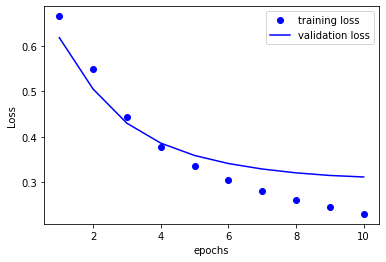

In [ ]:
history_dict = history.history
print("[INFO] history items:", history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

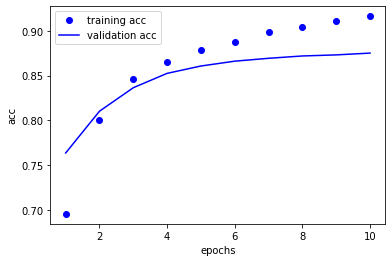

In [ ]:
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

### ※ ***Export the model***
We applied the TextVectorization layer to the dataset before feeding text to the model.    
**If We want to make your model capable of processing raw strings (for example, to simplify deploying it),     
you can include the TextVectorization layer inside your model.    
We can create a new model using the weights you just trained.**  


In [ ]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)
 
loss, acc = export_model.evaluate(raw_test_data)

print("[INFO] Loss value: {loss}\
       \n[INFO] Accuracy value: {accuracy}".format(
    loss=loss, accuracy=acc)
)

782/782 [==============================] - 9s 11ms/step - loss: 0.3104 - accuracy: 0.8724
[INFO] Loss value: 0.3104153573513031       
[INFO] Accuracy value: 0.8723599910736084


### ***Inference on new data***
To get predictions for new examples.

In [ ]:
examples = [
    "The movie was great!",
    "The movie was okay.",
    "The movie soooooo okay.",
    "The movie not bad.",
    "The movie was terrible..."
]

pred_array = export_model.predict(examples)

for example_text, pred_label in zip(examples, pred_array):
    print("[INFO] \"{example_text}\" positive rate: {pred_label}%.".format(
        example_text=example_text, pred_label=int((pred_label)*100))
    )

[INFO] "The movie was great!" positive rate: 60%.
[INFO] "The movie was okay." positive rate: 43%.
[INFO] "The movie soooooo okay." positive rate: 44%.
[INFO] "The movie not bad." positive rate: 34%.
[INFO] "The movie was terrible..." positive rate: 34%.
